In [2]:
!pip install wandb

In [3]:
import wandb

In [4]:
wandb.login(key='53b259076c07d0811d73bf26bfef7437e04dbf66')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma23m013 (ma23m013-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
data = '/kaggle/input/inaturalist-dataset'

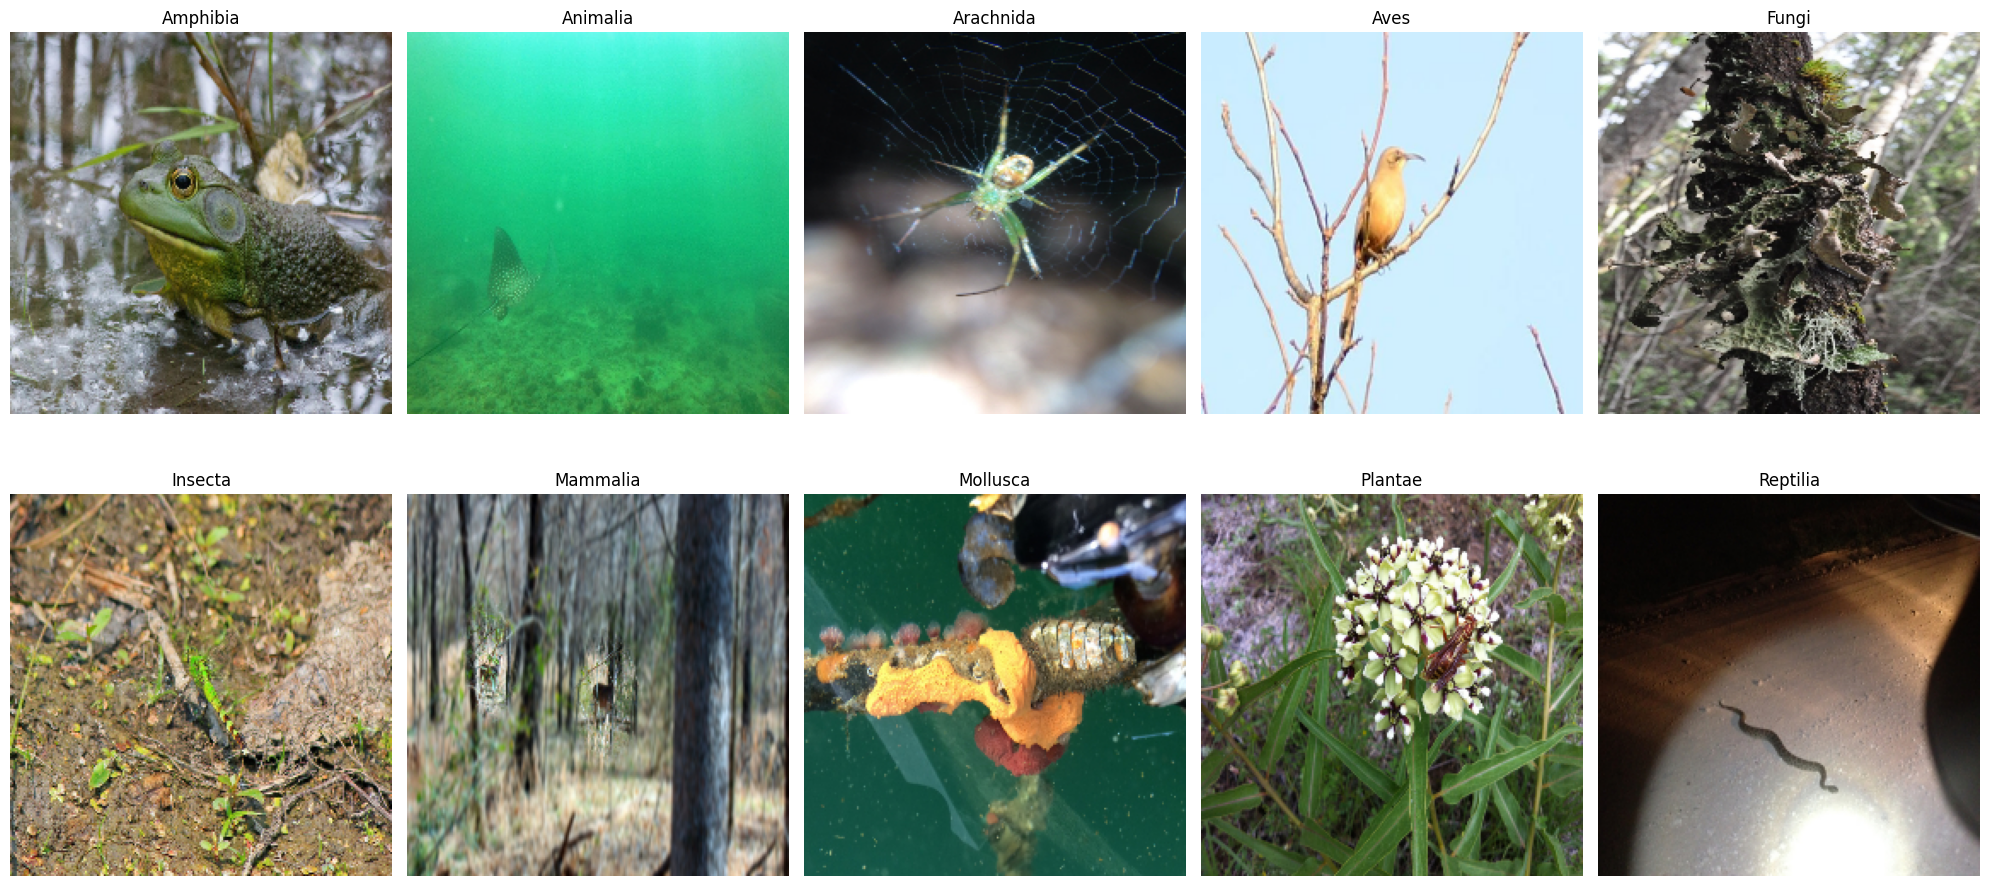

In [6]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define dataset paths
train_dir = '/kaggle/input/inaturalist-dataset/inaturalist_12K/train'
val_dir = '/kaggle/input/inaturalist-dataset/inaturalist_12K/val'

# List of class names (10 categories in iNaturalist subset)
class_labels = [
    'Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi',
    'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia'
]

# Image size to resize for display
image_size = (224, 224)

# Create a figure for visualization (2 rows x 5 columns)
fig = plt.figure(figsize=(20, 10))
num_rows, num_cols, subplot_index = 2, 5, 1

# Display one example image per class from the validation set
for class_name in class_labels:
    class_path = os.path.join(val_dir, class_name)
    
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        
        # Read and resize image
        image = mpimg.imread(image_path)
        image = cv2.resize(image, image_size)
        
        # Add image to subplot
        fig.add_subplot(num_rows, num_cols, subplot_index)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
        
        subplot_index += 1
        break  # Show only one image per class

plt.tight_layout()
plt.show()


## Part A: Training from scratch
Question 1:

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Helper function to compute output image size after convolution
def compute_output_size(input_size, kernel_size, padding, stride):
    return (1 / 2) * (1 + (input_size - kernel_size + (2 * padding)) / stride)

# Custom Convolutional Neural Network class
class CustomCNN(nn.Module):
    def __init__(self, input_channels=3, conv_filters=[32, 64, 128, 256, 512], kernel_sizes=[3, 3, 5, 5, 7],
                 activation_fn=nn.ReLU(), stride=1, padding=1, pooling_dim=(2, 2), dense_units=512, output_classes=10,
                 dropout_rate=0, use_batchnorm=True):
        super(CustomCNN, self).__init__()
        self.input_channels = input_channels
        self.conv_filters = conv_filters
        self.kernel_sizes = kernel_sizes
        self.activation_fn = activation_fn
        self.stride = stride
        self.padding = padding
        self.pooling_dim = pooling_dim
        self.dense_units = dense_units
        self.output_classes = output_classes
        self.dropout_rate = dropout_rate
        self.use_batchnorm = use_batchnorm

        # Define convolutional and dropout layers
        self.conv1 = nn.Conv2d(self.input_channels, self.conv_filters[0], self.kernel_sizes[0], stride=self.stride, padding=self.padding)
        self.dropout1 = nn.Dropout2d(self.dropout_rate)

        self.conv2 = nn.Conv2d(self.conv_filters[0], self.conv_filters[1], self.kernel_sizes[1], stride=self.stride, padding=self.padding)
        self.dropout2 = nn.Dropout2d(self.dropout_rate)

        self.conv3 = nn.Conv2d(self.conv_filters[1], self.conv_filters[2], self.kernel_sizes[2], stride=self.stride, padding=self.padding)
        self.dropout3 = nn.Dropout2d(self.dropout_rate)

        self.conv4 = nn.Conv2d(self.conv_filters[2], self.conv_filters[3], self.kernel_sizes[3], stride=self.stride, padding=self.padding)
        self.dropout4 = nn.Dropout2d(self.dropout_rate)

        self.conv5 = nn.Conv2d(self.conv_filters[3], self.conv_filters[4], self.kernel_sizes[4], stride=self.stride, padding=self.padding)
        self.dropout5 = nn.Dropout2d(self.dropout_rate)

        # Define batch normalization layers
        self.bn1 = nn.BatchNorm2d(self.conv_filters[0])
        self.bn2 = nn.BatchNorm2d(self.conv_filters[1])
        self.bn3 = nn.BatchNorm2d(self.conv_filters[2])
        self.bn4 = nn.BatchNorm2d(self.conv_filters[3])
        self.bn5 = nn.BatchNorm2d(self.conv_filters[4])

        # Define max pooling layer
        self.pooling = nn.MaxPool2d(self.pooling_dim, stride=2)

        # Compute final image size after convolutions and pooling (assuming input size is 224)
        out_size = 224
        for k in self.kernel_sizes:
            out_size = compute_output_size(out_size, k, self.padding, self.stride)
        out_size = int(out_size)

        # Fully connected layers
        self.flatten_dropout = nn.Dropout1d(self.dropout_rate)
        self.fc1 = nn.Linear(self.conv_filters[4] * out_size * out_size, self.dense_units)
        self.fc1_bn = nn.BatchNorm1d(self.dense_units)
        self.output_layer = nn.Linear(self.dense_units, self.output_classes)

    def forward(self, x):
        # Conv Layer 1
        x = self.conv1(x)
        if self.use_batchnorm: x = self.bn1(x)
        x = self.activation_fn(x)
        x = self.pooling(x)
        x = self.dropout1(x)

        # Conv Layer 2
        x = self.conv2(x)
        if self.use_batchnorm: x = self.bn2(x)
        x = self.activation_fn(x)
        x = self.pooling(x)
        x = self.dropout2(x)

        # Conv Layer 3
        x = self.conv3(x)
        if self.use_batchnorm: x = self.bn3(x)
        x = self.activation_fn(x)
        x = self.pooling(x)
        x = self.dropout3(x)

        # Conv Layer 4
        x = self.conv4(x)
        if self.use_batchnorm: x = self.bn4(x)
        x = self.activation_fn(x)
        x = self.pooling(x)
        x = self.dropout4(x)

        # Conv Layer 5
        x = self.conv5(x)
        if self.use_batchnorm: x = self.bn5(x)
        x = self.activation_fn(x)
        x = self.pooling(x)
        x = self.dropout5(x)

        # Flatten before fully connected layers
        x = x.reshape(x.size(0), -1)

        # Dense Layer
        x = self.fc1(x)
        if self.use_batchnorm: x = self.fc1_bn(x)
        x = self.activation_fn(x)
        x = self.flatten_dropout(x)

        # Output
        x = self.output_layer(x)
        return x

# Instantiate model and send to device
cnn_model = CustomCNN().to(device)
print(cnn_model)


CustomCNN(
  (activation_fn): ReLU()
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout2d(p=0, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (dropout3): Dropout2d(p=0, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (dropout4): Dropout2d(p=0, inplace=False)
  (conv5): Conv2d(256, 512, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (dropout5): Dropout2d(p=0, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [8]:
# Function to train the model using training data
def train_model(model, train_loader):
    # Define loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()  # Set model to training mode

    total_loss = 0.0
    total_correct_predictions = 0
    total_samples = 0

    # Loop over batches of training data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        predictions = model(images)  # Forward pass
        loss = loss_function(predictions, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters

        total_loss += loss.item()

        # Count correct predictions
        _, predicted_labels = torch.max(predictions, 1)
        total_correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader)
    training_accuracy = 100 * total_correct_predictions / total_samples

    return model, average_loss, training_accuracy


def evaluate_model(model, data_loader):
    """
    Evaluates the model using a given DataLoader and returns both loss and accuracy.
    
    Parameters:
    - model: The trained model.
    - data_loader: DataLoader for validation or test data.
    
    Returns:
    - avg_loss: Average loss over the dataset.
    - accuracy: Accuracy in percentage.
    """
    loss_function = nn.CrossEntropyLoss()  # Define the loss function
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_predictions = 0
    total_loss = 0.0

    with torch.no_grad():  # No gradient needed during evaluation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)  # Use predefined loss function
            total_loss += loss.item()

            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct_predictions / total_predictions
    return avg_loss, accuracy


In [9]:
# Function to train and validate the model for a number of epochs
def train_and_validate(model, train_loader, val_loader, num_epochs):
    # Define the loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training and validation loop
    for epoch in range(num_epochs):
        # Train the model on the training set
        model, average_train_loss, train_accuracy = train_model(model, train_loader)

        # Validate the model on the validation set
        avg_loss, accuracy = evaluate_model(model, val_loader)
        
        # Print training and validation performance for the current epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {average_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, '
              f'Validation Loss: {avg_loss:.4f}, '
              f'Validation Accuracy: {accuracy:.2f}%')

        # Log training and validation metrics to Weights & Biases
        wandb.log({'Epoch': epoch,
            'Train Loss': average_train_loss,
            'Train Accuracy': train_accuracy,
            'Validation Loss': avg_loss,
            'Validation Accuracy': accuracy})

    print('Model training and validation complete!')


In [10]:
def load_data(data_directory, apply_augmentation):
    """
    Loads image dataset from a given directory with optional data augmentation,
    and splits it into training and validation sets.

    Args:
        data_directory (str): Path to the image dataset.
        apply_augmentation (str): 'Yes' to apply augmentation, else no augmentation.

    Returns:
        train_loader (DataLoader): DataLoader for training dataset.
        val_loader (DataLoader): DataLoader for validation dataset.
    """

    # Define basic image transformations
    resize = transforms.Resize((224, 224))  # Resize to fixed input size
    to_tensor = transforms.ToTensor()       # Convert PIL Image to Tensor
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize

    # Augmentation-specific transformations
    random_resized_crop = transforms.RandomResizedCrop(224)
    horizontal_flip = transforms.RandomHorizontalFlip()
    color_shift = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    rotate = transforms.RandomRotation(20)

    # Define final transformation pipeline
    if apply_augmentation == 'Yes':
        transform_pipeline = transforms.Compose([
            random_resized_crop,
            horizontal_flip,
            color_shift,
            rotate,
            to_tensor,
            normalize
        ])
    else:
        transform_pipeline = transforms.Compose([
            resize,
            to_tensor,
            normalize
        ])

    # Load the dataset using ImageFolder with the defined transformations
    dataset = ImageFolder(root=data_directory, transform=transform_pipeline)

    # Split indices for training and validation (80-20 split)
    train_indices, val_indices = train_test_split(
        list(range(len(dataset))), test_size=0.2, random_state=42
    )

    # Create samplers for each subset
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Create DataLoaders for training and validation
    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

    return train_loader, val_loader


In [9]:
# Define configuration for WandB hyperparameter sweep using Bayesian optimization
sweep_configuration = {
    'method': 'bayes',  # Optimization method: Bayesian optimization
    'metric': {
        'name': 'val_accuracy',  # Metric to maximize
        'goal': 'maximize'
    },
    'parameters': {
        # Kernel size configurations for convolutional layers
        'conv_kernel_sizes': {
            'values': [
                [3, 3, 3, 3, 3],
                [3, 5, 5, 7, 7],
                [3, 5, 3, 5, 7],
                [5, 5, 5, 5, 5],
                [7, 7, 7, 7, 7]
            ]
        },
        # Dropout rates to try
        'dropout_rate': {
            'values': [0.3, 0.2]
        },
        # Activation functions to experiment with
        'activation_function': {
            'values': ['relu', 'mish', 'silu', 'gelu']
        },
        # Number of neurons in the fully connected (dense) layer
        'dense_layer_units': {
            'values': [128, 256]
        },
        # Whether to apply Batch Normalization or not
        'use_batch_norm': {
            'values': ['Yes', 'No']
        },
        # Filter (channel) sizes for each convolutional layer
        'conv_filters': {
            'values': [
                [128, 128, 64, 64, 32],
                [32, 64, 128, 256, 512],
                [32, 32, 32, 32, 32],
                [32, 64, 64, 128, 128]
            ]
        },
        # Whether to use data augmentation
        'apply_data_augmentation': {
            'values': ['Yes','No']
        }
    }
}

# Initialize the sweep in the specified WandB project
sweep_id = wandb.sweep(sweep=sweep_configuration, project='DA6401_Assignment-2')


Create sweep with ID: ofkd3yoh
Sweep URL: https://wandb.ai/ma23m013-iit-madras/DA6401_Assignment-2/sweeps/ofkd3yoh


In [ ]:
def main():
    '''
    This function is called by WandB for each sweep run with a unique combination 
    of hyperparameters. These values are accessed via wandb.config and used to 
    configure and train the CNN model.
    '''

    with wandb.init() as run:
        # Create a descriptive run name using hyperparameters
        run_name = (
            "ks" + str(wandb.config.conv_kernel_sizes) +
            "_ac-" + str(wandb.config.activation_function) +
            "_drop-" + str(wandb.config.dropout_rate) +
            "_aug-" + str(wandb.config.apply_data_augmentation) +
            "_filters-" + str(wandb.config.conv_filters) +
            "_bn-" + str(wandb.config.use_batch_norm) +
            "_dense-" + str(wandb.config.dense_layer_units)
        )
        wandb.run.name = run_name

        # Choose activation function based on configuration
        if wandb.config.activation_function == 'relu':
            activation_layer = nn.ReLU()
        elif wandb.config.activation_function == 'gelu':
            activation_layer = nn.GELU()
        elif wandb.config.activation_function == 'silu':
            activation_layer = nn.SiLU()
        elif wandb.config.activation_function == 'mish':
            activation_layer = nn.Mish()

        # Create the CNN model using the current sweep config
        cnn_model = CustomCNN(
            input_channels=3,
            conv_filters=wandb.config.conv_filters,
            kernel_sizes=wandb.config.conv_kernel_sizes,
            activation_fn=activation_layer,
            stride=1,
            padding=1,
            pooling_dim=(2, 2),
            dense_units=wandb.config.dense_layer_units,
            output_classes=10,
            dropout_rate=wandb.config.dropout_rate,
            use_batchnorm=wandb.config.use_batch_norm
        ).to(device)

        # Dataset directory path
        dataset_path = '/kaggle/input/inaturalist-dataset/inaturalist_12K/train'

        # Load training and validation data based on whether augmentation is applied
        train_loader, val_loader = load_data(dataset_path, apply_augmentation=wandb.config.apply_data_augmentation)

        # Train and validate the model
        train_and_validate(cnn_model, train_loader, val_loader, num_epochs=7)

# Run the sweep agent: calls `main()` function once (change count as needed)
wandb.agent(sweep_id, function=main, count=10)

# Finish WandB run
wandb.finish()


wandb: Agent Starting Run: v82h2z8a with config:
wandb: 	activation_function: mish
wandb: 	apply_data_augmentation: No
wandb: 	conv_filters: [32, 64, 128, 256, 512]
wandb: 	conv_kernel_sizes: [3, 5, 3, 5, 7]
wandb: 	dense_layer_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	use_batch_norm: No
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch 1/7, Train Loss: 2.1951, Train Accuracy: 19.15%, Validation Loss: 2.0665, Validation Accuracy: 26.10%
Epoch 2/7, Train Loss: 2.1308, Train Accuracy: 22.45%, Validation Loss: 2.0276, Validation Accuracy: 27.70%
Epoch 3/7, Train Loss: 2.0803, Train Accuracy: 24.74%, Validation Loss: 1.9881, Validation Accuracy: 30.35%
Epoch 4/7, Train Loss: 2.0392, Train Accuracy: 26.30%, Validation Loss: 1.9521, Validation Accuracy: 32.20%
Epoch 5/7, Train Loss: 2.0099, Train Accuracy: 27.43%, Validation Loss: 1.9370, Validation Accuracy: 32.30%
Epoch 6/7, Train Loss: 1.9981, Train Accuracy: 28.07%, Validation Loss: 1.8973, Validation Accuracy: 33.20%
Epoch 7/7, Train Loss: 1.9830, Train Accuracy: 28.24%, Validation Loss: 1.8827, Validation Accuracy: 34.55%
Model training and validation complete!


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vpqq5suj with config:
wandb: 	activation_function: relu
wandb: 	apply_data_augmentation: Yes
wandb: 	conv_filters: [128, 128, 64, 64, 32]
wandb: 	conv_kernel_sizes: [3, 5, 3, 5, 7]
wandb: 	dense_layer_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	use_batch_norm: No


Epoch 1/7, Train Loss: 2.2832, Train Accuracy: 14.58%, Validation Loss: 2.1950, Validation Accuracy: 19.45%
Epoch 2/7, Train Loss: 2.2465, Train Accuracy: 16.21%, Validation Loss: 2.1716, Validation Accuracy: 20.75%
Epoch 3/7, Train Loss: 2.2163, Train Accuracy: 18.96%, Validation Loss: 2.1570, Validation Accuracy: 20.55%
Epoch 4/7, Train Loss: 2.2007, Train Accuracy: 18.65%, Validation Loss: 2.1426, Validation Accuracy: 21.70%
Epoch 5/7, Train Loss: 2.1932, Train Accuracy: 19.21%, Validation Loss: 2.1652, Validation Accuracy: 21.05%
Epoch 6/7, Train Loss: 2.1911, Train Accuracy: 19.03%, Validation Loss: 2.1226, Validation Accuracy: 23.65%
Epoch 7/7, Train Loss: 2.1883, Train Accuracy: 19.59%, Validation Loss: 2.1188, Validation Accuracy: 24.10%
Model training and validation complete!


wandb: Agent Starting Run: qoy2vbd6 with config:
wandb: 	activation_function: relu
wandb: 	apply_data_augmentation: No
wandb: 	conv_filters: [32, 32, 32, 32, 32]
wandb: 	conv_kernel_sizes: [7, 7, 7, 7, 7]
wandb: 	dense_layer_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	use_batch_norm: No


Epoch 1/7, Train Loss: 2.3416, Train Accuracy: 11.96%, Validation Loss: 2.2349, Validation Accuracy: 18.00%
Epoch 2/7, Train Loss: 2.2790, Train Accuracy: 14.74%, Validation Loss: 2.2121, Validation Accuracy: 19.00%
Epoch 3/7, Train Loss: 2.2567, Train Accuracy: 14.79%, Validation Loss: 2.1869, Validation Accuracy: 21.40%
Epoch 4/7, Train Loss: 2.2340, Train Accuracy: 17.15%, Validation Loss: 2.1586, Validation Accuracy: 20.95%
Epoch 5/7, Train Loss: 2.2148, Train Accuracy: 17.83%, Validation Loss: 2.1657, Validation Accuracy: 20.15%
Epoch 6/7, Train Loss: 2.2063, Train Accuracy: 18.01%, Validation Loss: 2.1296, Validation Accuracy: 22.00%
Epoch 7/7, Train Loss: 2.1990, Train Accuracy: 18.36%, Validation Loss: 2.1417, Validation Accuracy: 22.15%
Model training and validation complete!


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 420w2cog with config:
wandb: 	activation_function: silu
wandb: 	apply_data_augmentation: No
wandb: 	conv_filters: [32, 64, 64, 128, 128]
wandb: 	conv_kernel_sizes: [7, 7, 7, 7, 7]
wandb: 	dense_layer_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	use_batch_norm: Yes


Epoch 1/7, Train Loss: 2.2486, Train Accuracy: 16.56%, Validation Loss: 2.1573, Validation Accuracy: 22.40%
Epoch 2/7, Train Loss: 2.1876, Train Accuracy: 19.53%, Validation Loss: 2.0931, Validation Accuracy: 22.50%
Epoch 3/7, Train Loss: 2.1614, Train Accuracy: 20.58%, Validation Loss: 2.0952, Validation Accuracy: 23.65%
Epoch 4/7, Train Loss: 2.1237, Train Accuracy: 22.08%, Validation Loss: 2.0323, Validation Accuracy: 26.80%
Epoch 5/7, Train Loss: 2.0930, Train Accuracy: 22.99%, Validation Loss: 2.0271, Validation Accuracy: 27.65%
Epoch 6/7, Train Loss: 2.0815, Train Accuracy: 23.95%, Validation Loss: 1.9908, Validation Accuracy: 28.80%
Epoch 7/7, Train Loss: 2.0606, Train Accuracy: 25.14%, Validation Loss: 1.9673, Validation Accuracy: 30.45%
Model training and validation complete!


wandb: Agent Starting Run: 1ruugl7f with config:
wandb: 	activation_function: gelu
wandb: 	apply_data_augmentation: No
wandb: 	conv_filters: [128, 128, 64, 64, 32]
wandb: 	conv_kernel_sizes: [3, 5, 5, 7, 7]
wandb: 	dense_layer_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	use_batch_norm: Yes


Epoch 1/7, Train Loss: 2.2605, Train Accuracy: 15.64%, Validation Loss: 2.1680, Validation Accuracy: 20.95%
Epoch 2/7, Train Loss: 2.2038, Train Accuracy: 18.46%, Validation Loss: 2.1057, Validation Accuracy: 26.45%
Epoch 3/7, Train Loss: 2.1641, Train Accuracy: 19.30%, Validation Loss: 2.0958, Validation Accuracy: 24.60%
Epoch 4/7, Train Loss: 2.1452, Train Accuracy: 20.68%, Validation Loss: 2.0503, Validation Accuracy: 28.35%
Epoch 5/7, Train Loss: 2.1426, Train Accuracy: 20.79%, Validation Loss: 2.0493, Validation Accuracy: 27.85%
Epoch 6/7, Train Loss: 2.1158, Train Accuracy: 21.90%, Validation Loss: 2.0324, Validation Accuracy: 28.15%
Epoch 7/7, Train Loss: 2.1037, Train Accuracy: 21.99%, Validation Loss: 2.0145, Validation Accuracy: 29.60%
Model training and validation complete!


wandb: Agent Starting Run: codo3xl1 with config:
wandb: 	activation_function: silu
wandb: 	apply_data_augmentation: Yes
wandb: 	conv_filters: [32, 64, 64, 128, 128]
wandb: 	conv_kernel_sizes: [5, 5, 5, 5, 5]
wandb: 	dense_layer_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	use_batch_norm: Yes


Epoch 1/7, Train Loss: 2.2893, Train Accuracy: 14.58%, Validation Loss: 2.2262, Validation Accuracy: 19.90%
Epoch 2/7, Train Loss: 2.2530, Train Accuracy: 15.68%, Validation Loss: 2.2240, Validation Accuracy: 18.25%
Epoch 3/7, Train Loss: 2.2387, Train Accuracy: 16.61%, Validation Loss: 2.1949, Validation Accuracy: 20.20%
Epoch 4/7, Train Loss: 2.2239, Train Accuracy: 17.23%, Validation Loss: 2.1724, Validation Accuracy: 21.55%
Epoch 5/7, Train Loss: 2.2072, Train Accuracy: 18.33%, Validation Loss: 2.1650, Validation Accuracy: 21.95%
Epoch 6/7, Train Loss: 2.1927, Train Accuracy: 19.65%, Validation Loss: 2.1429, Validation Accuracy: 24.25%
Epoch 7/7, Train Loss: 2.1880, Train Accuracy: 19.50%, Validation Loss: 2.1505, Validation Accuracy: 22.60%
Model training and validation complete!


wandb: Agent Starting Run: ik6zfum3 with config:
wandb: 	activation_function: gelu
wandb: 	apply_data_augmentation: Yes
wandb: 	conv_filters: [32, 64, 128, 256, 512]
wandb: 	conv_kernel_sizes: [5, 5, 5, 5, 5]
wandb: 	dense_layer_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	use_batch_norm: No


In [11]:
# Function to load and preprocess test image dataset with optional data augmentation
def load_test_dataset(test_directory, apply_data_augmentation):
    # Define basic image transformation operations
    resize_transform = transforms.Resize((224, 224))
    tensor_transform = transforms.ToTensor()
    normalization_transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    # Define data augmentation transformations
    random_crop = transforms.RandomResizedCrop(224)
    horizontal_flip = transforms.RandomHorizontalFlip()
    color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    random_rotation = transforms.RandomRotation(20)

    # Compose transformations based on whether augmentation is enabled
    if apply_data_augmentation == 'Yes':
        composed_transforms = transforms.Compose([
            random_crop,
            horizontal_flip,
            color_jitter,
            random_rotation,
            tensor_transform,
            normalization_transform
        ])
    else:
        composed_transforms = transforms.Compose([
            resize_transform,
            tensor_transform,
            normalization_transform
        ])

    # Load the test dataset using ImageFolder and apply selected transformations
    test_dataset = ImageFolder(root=test_directory, transform=composed_transforms)

    # Create DataLoader for the test dataset with a fixed batch size
    test_loader = DataLoader(test_dataset, batch_size=32)

    return test_loader


In [12]:
import os
import cv2
import random
import imageio.v2

def plot_sample_predictions(trained_model):
    """
    Plots a grid of 30 randomly selected validation images and their predicted labels using the trained model.
    Also logs the figure to Weights & Biases (wandb).

    Parameters:
    - trained_model: The trained CNN model to use for predictions.
    """

    # List of class names
    class_names = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi',
                   'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
    
    # Path to validation dataset
    val_data_dir = '/kaggle/input/inaturalist-dataset/inaturalist_12K/val'

    images_list = []     # Stores image data
    labels_list = []     # Stores true labels

    # Randomly select 3 images from each class (total 30)
    for label_index, class_label in enumerate(class_names):
        image_filenames = os.listdir(os.path.join(val_data_dir, class_label))
        selected_images = random.sample(image_filenames, 3)

        for filename in selected_images:
            image_path = os.path.join(val_data_dir, class_label, filename)
            image = imageio.v2.imread(image_path)
            if image.ndim == 3:  # Ensure image has 3 channels
                resized_image = cv2.resize(image, (224, 224))
                images_list.append(resized_image)
                labels_list.append(class_label)

    # Normalize and convert to tensor
    image_array = np.array(images_list).astype('float32') / 255.0
    image_array = np.transpose(image_array, (0, 3, 1, 2))  # Convert to (B, C, H, W)
    image_tensor = torch.tensor(image_array).to(device)

    # Model predictions
    trained_model.eval()
    with torch.no_grad():
        predictions = trained_model(image_tensor)
        predicted_indices = torch.argmax(predictions, dim=1)

    # Create figure for display
    fig, axes = plt.subplots(10, 3, figsize=(12, 20))
    for i in range(10):
        for j in range(3):
            idx = i * 3 + j
            axes[i, j].imshow(images_list[idx])
            pred_class = class_names[predicted_indices[idx].item()]
            true_class = labels_list[idx]
            axes[i, j].set_title(f"True: {true_class}\nPred: {pred_class}")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

    # Save figure and log to wandb
    fig.savefig("predicted_images_grid.png", bbox_inches='tight')
    wandb.log({"Predicted Images": [wandb.Image("predicted_images_grid.png", caption="Validation Predictions")]})


In [13]:
def train_and_test_model(cnn_model, train_loader, test_loader, num_epochs):
    """
    Trains the CNN model and evaluates it on the test data.
    Logs training and test metrics using Weights & Biases (wandb).

    Parameters:
    - cnn_model: the CNN model to be trained
    - train_loader: DataLoader for the training data
    - test_loader: DataLoader for the test data
    - num_epochs: number of training epochs
    """

    # Define loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        # Train the model and get training loss and accuracy
        cnn_model, train_loss, train_accuracy = train_model(cnn_model, train_loader)

        # Print and log training metrics
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        wandb.log({'Train Loss': train_loss, 'Train Accuracy': train_accuracy})

    # Evaluate the model on test data
    test_loss, test_accuracy = evaluate_model(cnn_model, test_loader)

    # Log and print test accuracy and loss
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    wandb.log({'Test Loss': test_loss, 'Test Accuracy': test_accuracy, 'Epoch': num_epochs})

    # Plot predictions
    plot_sample_predictions(cnn_model)

    # Finish the wandb run
    wandb.finish()

    print('Training complete!')


In [16]:
# Define configuration for WandB hyperparameter sweep using Bayesian optimization
sweep_configuration = {
    'method': 'bayes',  # Optimization method: Bayesian optimization
    'metric': {
        'name': 'val_accuracy',  # Metric to maximize
        'goal': 'maximize'
    },
    'parameters': {
        # Kernel size configurations for convolutional layers
        'conv_kernel_sizes': {
            'values': [
                [3, 3, 3, 3, 3]
            ]
        },
        # Dropout rates to try
        'dropout_rate': {
            'values': [0.3]
        },
        # Activation functions to experiment with
        'activation_function': {
            'values': ['mish']
        },
        # Number of neurons in the fully connected (dense) layer
        'dense_layer_units': {
            'values': [128]
        },
        # Whether to apply Batch Normalization or not
        'use_batch_norm': {
            'values': ['Yes']
        },
        # Filter (channel) sizes for each convolutional layer
        'conv_filters': {
            'values': [
                [128, 128, 64, 64, 32],
                [32, 32, 32, 32, 32]
            ]
        },
        # Whether to use data augmentation
        'apply_data_augmentation': {
            'values': ['No']
        }
    }
}

# Initialize the sweep in the specified WandB project
sweep_id = wandb.sweep(sweep=sweep_configuration, project='DA6401_Assignment-2')


Create sweep with ID: 4j4uykk2
Sweep URL: https://wandb.ai/ma23m013-iit-madras/DA6401_Assignment-2/sweeps/4j4uykk2


wandb: Agent Starting Run: u17ccnmn with config:
wandb: 	activation_function: mish
wandb: 	apply_data_augmentation: No
wandb: 	conv_filters: [32, 32, 32, 32, 32]
wandb: 	conv_kernel_sizes: [3, 3, 3, 3, 3]
wandb: 	dense_layer_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	use_batch_norm: Yes
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch 1/7, Train Loss: 2.2762, Train Accuracy: 14.53%
Epoch 2/7, Train Loss: 2.2090, Train Accuracy: 17.24%
Epoch 3/7, Train Loss: 2.1745, Train Accuracy: 19.61%
Epoch 4/7, Train Loss: 2.1467, Train Accuracy: 20.84%
Epoch 5/7, Train Loss: 2.1286, Train Accuracy: 21.38%
Epoch 6/7, Train Loss: 2.1164, Train Accuracy: 22.00%
Epoch 7/7, Train Loss: 2.1026, Train Accuracy: 22.14%
Test Loss: 1.9656, Test Accuracy: 33.30%


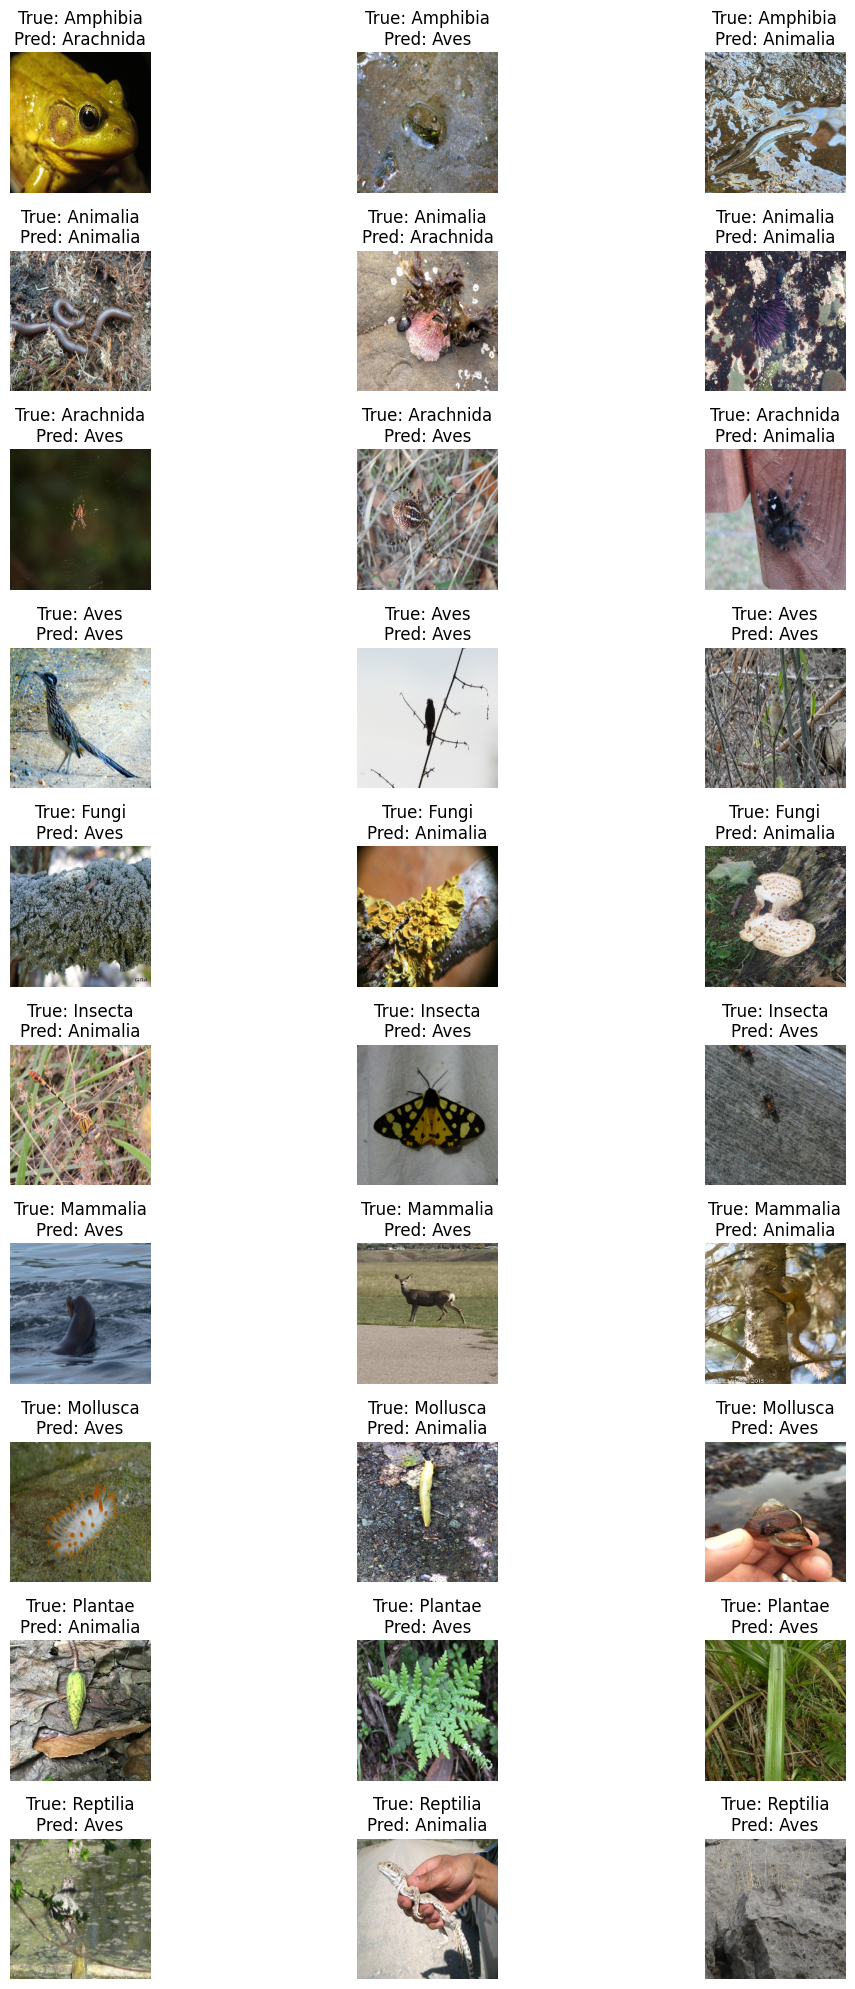

Training complete!


wandb: Agent Starting Run: 7feub54d with config:
wandb: 	activation_function: mish
wandb: 	apply_data_augmentation: No
wandb: 	conv_filters: [128, 128, 64, 64, 32]
wandb: 	conv_kernel_sizes: [3, 3, 3, 3, 3]
wandb: 	dense_layer_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	use_batch_norm: Yes


Epoch 1/7, Train Loss: 2.2292, Train Accuracy: 17.28%
Epoch 2/7, Train Loss: 2.1577, Train Accuracy: 19.33%
Epoch 3/7, Train Loss: 2.1303, Train Accuracy: 21.65%
Epoch 4/7, Train Loss: 2.0978, Train Accuracy: 22.63%
Epoch 5/7, Train Loss: 2.0797, Train Accuracy: 22.80%
Epoch 6/7, Train Loss: 2.0715, Train Accuracy: 24.09%
Epoch 7/7, Train Loss: 2.0367, Train Accuracy: 25.19%
Test Loss: 1.9219, Test Accuracy: 34.70%


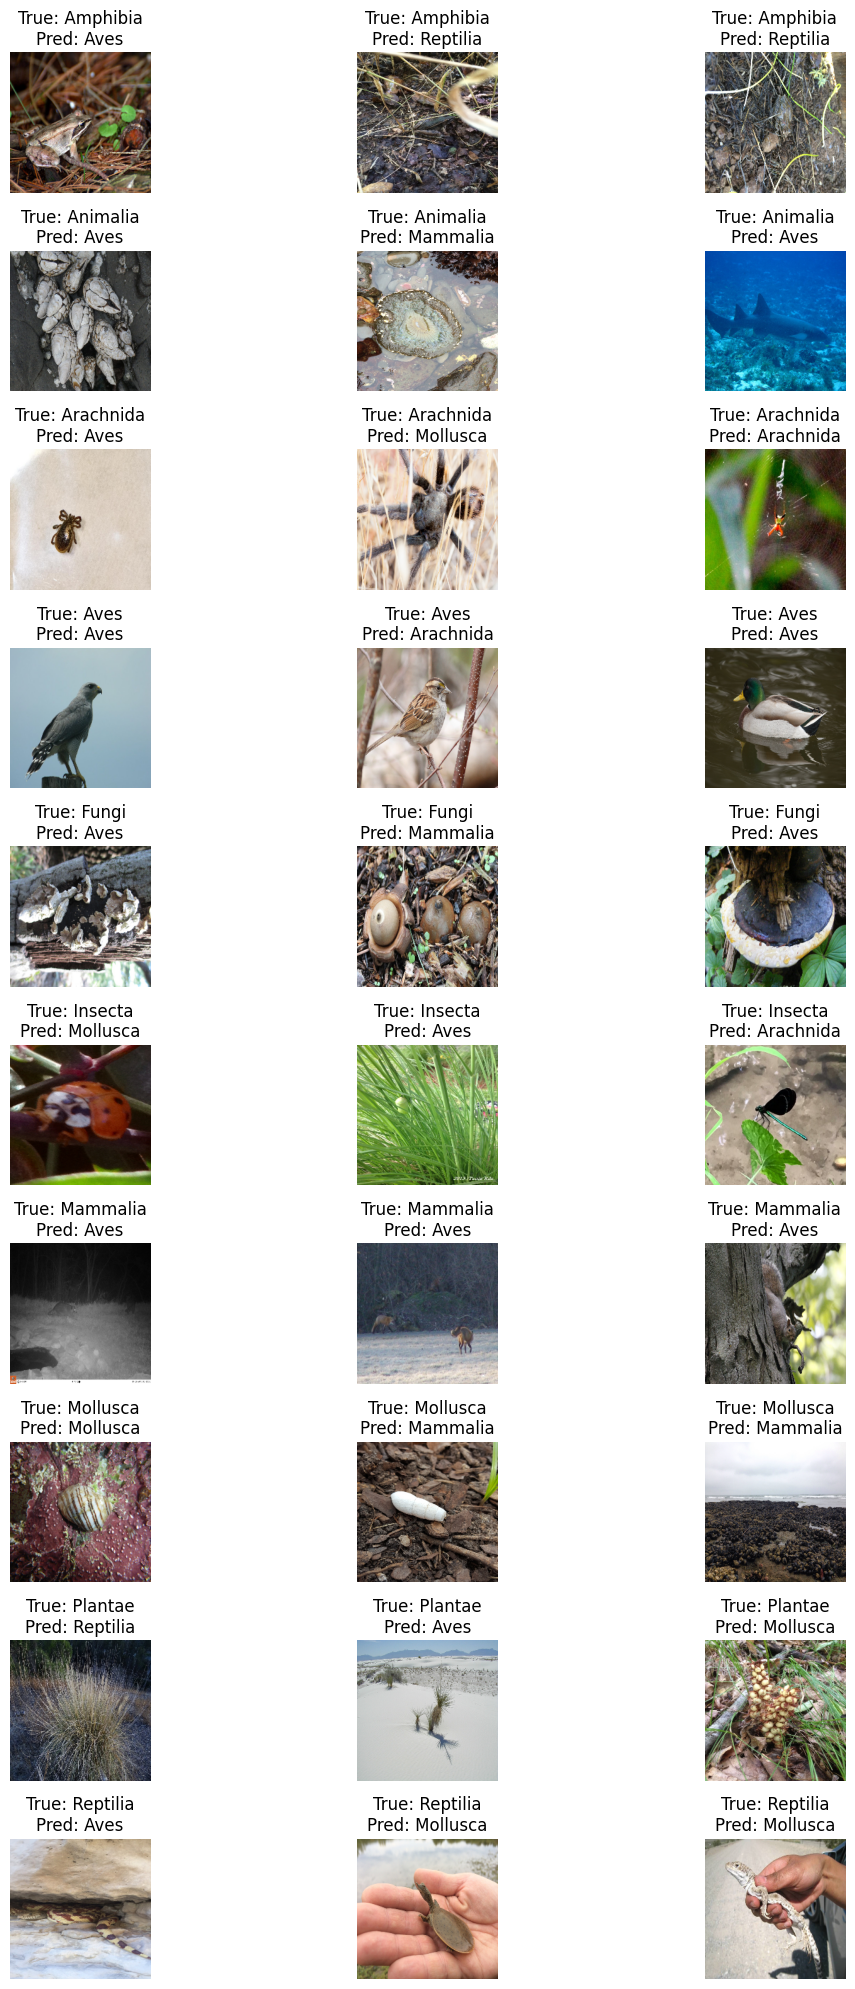

Training complete!


wandb: Agent Starting Run: 9y19uosv with config:
wandb: 	activation_function: mish
wandb: 	apply_data_augmentation: No
wandb: 	conv_filters: [128, 128, 64, 64, 32]
wandb: 	conv_kernel_sizes: [3, 3, 3, 3, 3]
wandb: 	dense_layer_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	use_batch_norm: Yes


Epoch 1/7, Train Loss: 2.2257, Train Accuracy: 17.69%
Epoch 2/7, Train Loss: 2.1552, Train Accuracy: 20.77%
Epoch 3/7, Train Loss: 2.1215, Train Accuracy: 21.73%
Epoch 4/7, Train Loss: 2.0816, Train Accuracy: 23.05%
Epoch 5/7, Train Loss: 2.0758, Train Accuracy: 23.82%
Epoch 6/7, Train Loss: 2.0698, Train Accuracy: 24.05%
Epoch 7/7, Train Loss: 2.0401, Train Accuracy: 25.23%
Test Loss: 1.9158, Test Accuracy: 33.85%


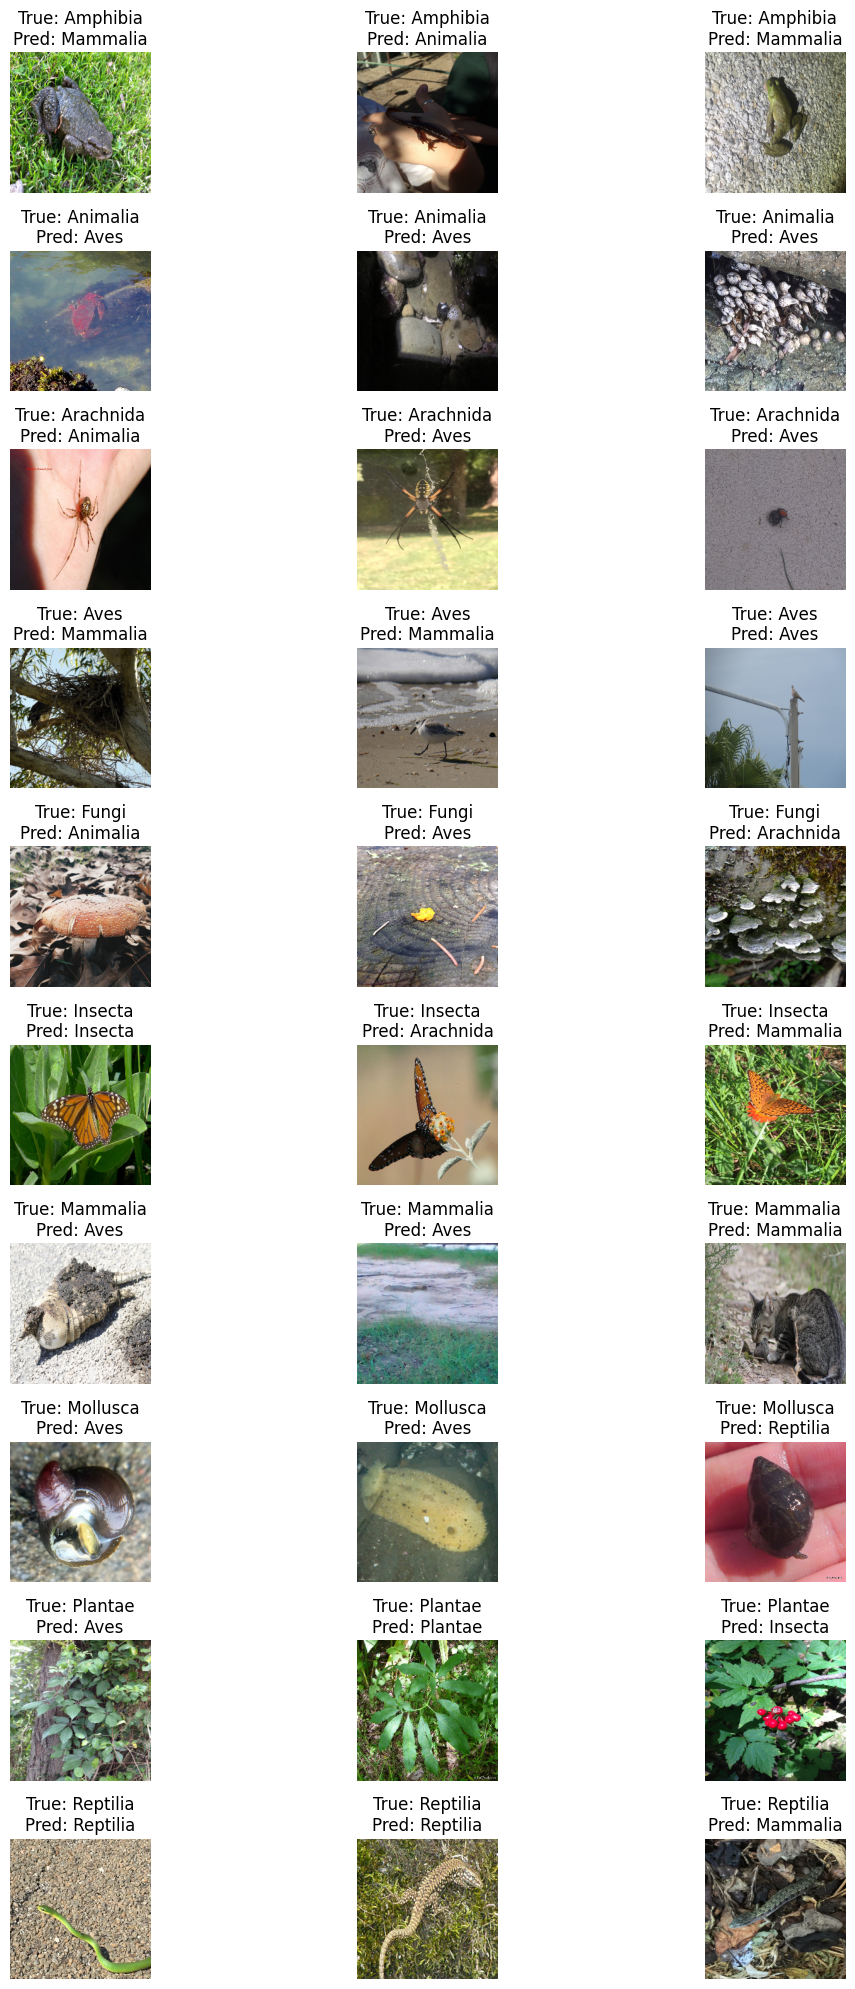

Training complete!


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3xpmamu5 with config:
wandb: 	activation_function: mish
wandb: 	apply_data_augmentation: No
wandb: 	conv_filters: [32, 32, 32, 32, 32]
wandb: 	conv_kernel_sizes: [3, 3, 3, 3, 3]
wandb: 	dense_layer_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	use_batch_norm: Yes


Epoch 1/7, Train Loss: 2.2790, Train Accuracy: 14.61%


In [ ]:
def main():
    '''
    This function is called by WandB for each sweep run with a unique combination 
    of hyperparameters. These values are accessed via wandb.config and used to 
    configure and train the CNN model.
    '''

    with wandb.init() as run:
        # Create a descriptive run name using hyperparameters
        run_name = (
            "ks" + str(wandb.config.conv_kernel_sizes) +
            "_ac-" + str(wandb.config.activation_function) +
            "_drop-" + str(wandb.config.dropout_rate) +
            "_aug-" + str(wandb.config.apply_data_augmentation) +
            "_filters-" + str(wandb.config.conv_filters) +
            "_bn-" + str(wandb.config.use_batch_norm) +
            "_dense-" + str(wandb.config.dense_layer_units)
        )
        wandb.run.name = run_name

        # Choose activation function based on configuration
        if wandb.config.activation_function == 'relu':
            activation_layer = nn.ReLU()
        elif wandb.config.activation_function == 'gelu':
            activation_layer = nn.GELU()
        elif wandb.config.activation_function == 'silu':
            activation_layer = nn.SiLU()
        elif wandb.config.activation_function == 'mish':
            activation_layer = nn.Mish()

        # Create the CNN model using the current sweep config
        cnn_model = CustomCNN(
            input_channels=3,
            conv_filters=wandb.config.conv_filters,
            kernel_sizes=wandb.config.conv_kernel_sizes,
            activation_fn=activation_layer,
            stride=1,
            padding=1,
            pooling_dim=(2, 2),
            dense_units=wandb.config.dense_layer_units,
            output_classes=10,
            dropout_rate=wandb.config.dropout_rate,
            use_batchnorm=wandb.config.use_batch_norm
        ).to(device)

        # Dataset directory path
        dataset_path = '/kaggle/input/inaturalist-dataset/inaturalist_12K/train'

        # Load training and validation data based on whether augmentation is applied
        train_loader, val_loader = load_data(dataset_path, apply_augmentation=wandb.config.apply_data_augmentation)

        # Test Dataset directory path
        test_data_dir = '/kaggle/input/inaturalist-dataset/inaturalist_12K/val'
        test_loader = load_test_dataset(test_data_dir, apply_data_augmentation=wandb.config.apply_data_augmentation)
        
        # Train and test the model
        train_and_test_model(cnn_model, train_loader, test_loader, num_epochs=7)

# Run the sweep agent: calls `main()` function once (change count as needed)
wandb.agent(sweep_id, function=main, count=10)

# Finish WandB run
wandb.finish()
